In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.fftpack import fft,ifft
from scipy.io import wavfile
from scipy.signal import spectrogram
import IPython
from estimation import*
% matplotlib inline

# Récupération du signal audio

In [2]:
Fs,X = wavfile.read('data/aeiou.wav')
X = np.float64(X)
T = len(X)
print(Fs)
# spectrogramme 
Nfft = 2**7
f,t,spec = spectrogram(X,nfft=Nfft,nperseg=Nfft/2)

11025


C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


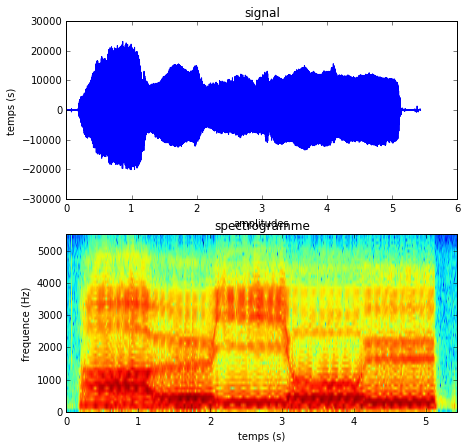

In [3]:
fig,ax = plt.subplots(2,1,figsize=(7,7))
ax[0].plot(np.arange(T)/Fs,X)
ax[0].set_title("signal")
ax[0].set_xlabel("amplitudes")
ax[0].set_ylabel("temps (s)")

ax[1].imshow(20*np.log10(spec[0:Nfft/2,:]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
ax[1].set_title("spectrogramme")
ax[1].set_xlabel("temps (s)")
ax[1].set_ylabel("frequence (Hz)")

IPython.display.Audio(X, rate=Fs)

# Estimateur

In [4]:
def generation_est2(X, d, T, mu):
    theta_est = np.zeros((d,T),dtype='double')
    X_pred = np.zeros(T,dtype='double')

    XX = X[0:d][::-1]
    for t in np.arange(d,T):
        XX = X[t-d:t][::-1]
        X_pred[t] = np.dot(theta_est[:,t-1].T,XX)

        err = X[t]-X_pred[t]
        
        theta_est[:,t] = theta_est[:,t-1] + mu*XX/(1+mu*np.linalg.norm(XX)**2)*err
    return X_pred, theta_est


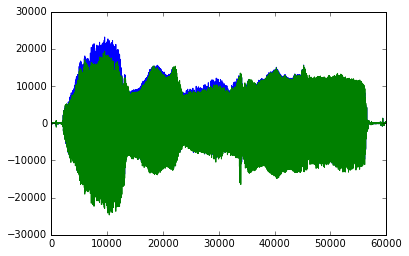

In [5]:
mu = 0.1
d = 20
X_est, theta_est = generation_est2(X, d, T, mu)
plt.plot(X)
plt.plot(X_est)

# Analyse spectrale

In [6]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -theta_est #polynome caractértistique

freq, dsp_X_est = dsp(coeffs_est, T, Nfft)

print(dsp_X_est.shape)

(128, 59964)


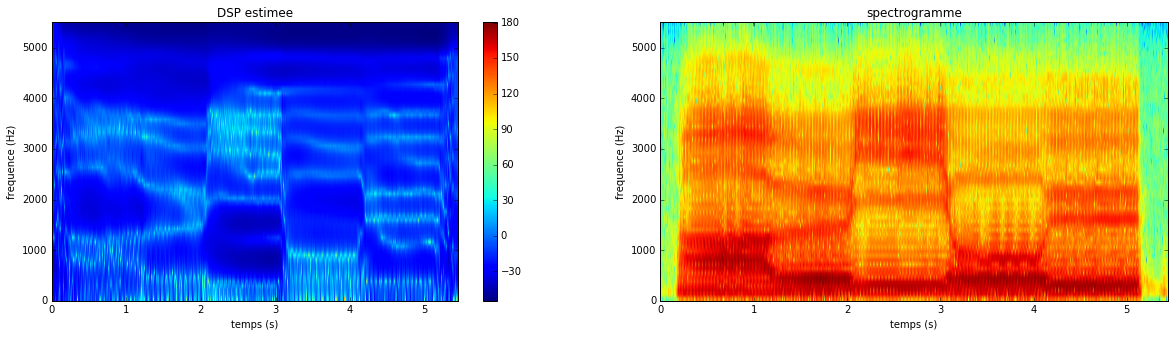

In [7]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
im=ax[0].imshow(20*np.log10(dsp_X_est[:Nfft/2,:]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("temps (s)")
ax[0].set_ylabel("frequence (Hz)")
ax[0].set_title("DSP estimee")
    
ax[1].imshow(20*np.log10(spec),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
ax[1].set_title("spectrogramme")
ax[1].set_xlabel("temps (s)")
ax[1].set_ylabel("frequence (Hz)")

plt.show()

### Génération à partir des coeff estimés

C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


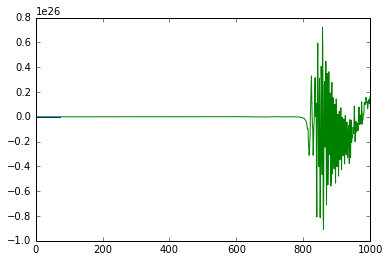

In [14]:
epsilon = np.zeros(T,dtype='double')
periode = 1./440 * Fs
for k in np.arange(T/periode):
    epsilon[k*periode] = 10;

plt.plot(epsilon[0:3*periode])

X_new = epsilon
for t in np.arange(d,T):
    X_new[t] = np.dot(theta_est[:,t].T,X_new[t-d:t][::-1]) + epsilon[t]

plt.plot(X_new[0:1000])


#### Agrégation 

In [ ]:
def aggregation(X, predictions, estimations, d, T, eta, strategy = 1):    
    # predictions : N*T
    # estimations : N*d*T
    N = predictions.shape[0]
    pred = np.zeros(T,dtype='double')
    estim = np.zeros((d,T), dtype='double')
    # Initialisation :
    alpha = 1./N*np.ones(N,dtype='double')
    pred[0] = np.dot(predictions[:,0].T,alpha)
    estim[:,0] = np.dot(estimations[:,:,0].T,alpha)
    
    # Mise a jour :
    for t in np.arange(1,T):
        v = np.zeros(N,dtype='double')
        for i in np.arange(N):
            if strategy==1:
                v[i]=alpha[i]*np.exp(-2*eta*(pred[t-1]-X[t-1])*predictions[i,t-1])
            else:
                v[i]=alpha[i]*np.exp(-eta*(predictions[i,t-1]-X[t-1])**2)
        #if t < 5:
         #   print(predictions[t-1])
            #print(pred[t])
            #print(v)
        alpha= v / np.sum(v)
        
        pred[t] = np.dot(predictions[:,t].T,alpha)
        estim[:,t] = np.dot(estimations[:,:,t].T,alpha)
        
    return pred,estim

In [ ]:
log_mu = np.arange(-2, -1, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)

X_pred = np.zeros((N,T),dtype='double')
theta_estim = np.zeros((N,d,T),dtype='double')

eta = np.sqrt(np.log(np.ceil(np.log(T)))/T)


for k in np.arange(N):
    X_pred[k,:],theta_estim[k,:,:] = generation_est2(X, d, T, mu[k])

pred_agr, estim_agr = aggregation(X, X_pred, theta_estim, d,T, eta, 1)
pred_agr2, estim_agr2 = aggregation(X, X_pred, theta_estim, d,T, eta, 2)

In [ ]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -estim_agr

coeffs_est2 = np.ones((d+1,T),dtype='complex')
coeffs_est2[1:,:] = -estim_agr2

f, dsp_X_est = dsp(coeffs_est, T, Nfft)
f, dsp_X_est2 = dsp(coeffs_est2, T, Nfft)


fig,ax = plt.subplots(1,3,figsize=(30,10))
fsize=18
    
ax[0].imshow(20*np.log10(spec),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
ax[0].set_title("spectrogramme", fontsize=fsize+2)
ax[0].set_xlabel("temps (s)", fontsize=fsize)
ax[0].set_ylabel("frequence (Hz)",fontsize=fsize)

im2=ax[1].imshow(20*np.log10(dsp_X_est[:Nfft/2]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("temps (s)",fontsize=fsize)
ax[1].set_ylabel("frequence (Hz)",fontsize=fsize)
ax[1].set_title("DSP estimee, strategie 1",fontsize=fsize+2)

im2=ax[2].imshow(20*np.log10(dsp_X_est2[:Nfft/2]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
plt.colorbar(im2,ax=ax[2])
ax[2].set_xlabel("temps (s)",fontsize=fsize)
ax[2].set_ylabel("frequence (Hz)",fontsize=fsize)
ax[2].set_title("DSP estimee, strategie 2",fontsize=fsize+2)

plt.show()